# Face Detection Project
** Hanxiao Yan, New York University**

## Introduction:
**Background:** 
In recent years, face detection problem has been more and more popular and attractive to almost every single person in modern society. Face detection system is a computer application capable of identifying or verifying a person from a digital image or a video frame from a video source. One of the ways to do this is by comparing selected facial features from the image and a face database. Since I really interested in face detection field, I would like to begin this project to do facial detection by building model myself.

**Object of this project:** 
Accomplish facial detection implementation by using machine learning knowledges, especially convolutional neural network.

**My idea:** 
At first, I would like to create a fully connected CNN (no FC layer at all), and then train this neural network on small images and set up CNN to output a 1x1x1 output. Then run the CNN on larger image, it will output the score for each box in the input image. While I would like to start my project with a more basic model, I append FC layers after CNN layers in my model. I build this model with the following steps:

- step1: Transfer learning from well-known model (VGG-16), this could save our time to train model from scrach.
- step2: Add our own layers (FC layers) to VGG-16 and obtain our model.
- step3: Download human pictures and generate face images as part of training samples.
- step4: Training model

After model being built, I try to:
- step1: Single face detection
- step2: Multi face detection

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Data details:
In project, I use:
- The input of **training image** is a batch of images with shape (m, 64, 64, 3), m samples and each is 64(Height)x64(Width)x3(RGB). Label y=1, non-face. Label y=0, face.
- The model output is a **score** (decimal number) which represent the probabilty that whether the corresponding input is a face or an non-face. 
- The input of **testing image** is one image of shape (512, 512, 3).

## Ⅰ - Building Model

#### 1-Transfer Learning
Limited to my computation power, I use pre-trained model, and I select well-known model VGG-16.

In [3]:
# Clear session at first
keras.backend.clear_session()
# Load the VGG16 network
input_shape = (64, 64, 3)
base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, input_shape=input_shape)

In [4]:
# Create a new model, but freeze the weights in VGG-16
model = Sequential()
# Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False

#### 2-Add Additional Layers to VGG-16

In [5]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### 3-Load Training Data

Use flicker API and Google downloading human images, then generate face images. In training images, there are face class images and non-face images. I then upload my own pictures to test if facial detection works.

In [6]:
train_data_dir = './train'
batch_size = 50
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(64,64),
                        batch_size=batch_size,
                        class_mode='binary')

Found 454 images belonging to 2 classes.


In [7]:
test_data_dir = './test'
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(512,512),
                        batch_size=batch_size,
                        class_mode='binary')

Found 1 images belonging to 1 classes.


#### Extract Testing Data

In [8]:
Xtest = test_generator.next()[0]

#### 3.1-Display Image

In [9]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

#### 3.2-Check Training Images

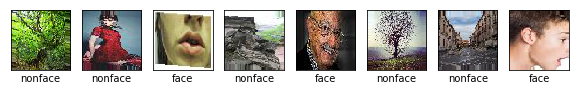

In [10]:
X = train_generator.next()
plt.figure(figsize=(10,10))
nplot = 8
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(X[0][i,:,:,:])
    if X[1][i].astype(int)==1:
        plt.xlabel('nonface')
    elif X[1][i].astype(int)==0:
        plt.xlabel('face')

#### 4-Training Model

#### 4.1-Select Optimizer and Compile Model

In [11]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 4.2-Use Training Data Train Model

In [12]:
model.fit(x=X[0], y=X[1])

Epoch 1/10
50/50 [==============================] - 3s - loss: 0.7951 - acc: 0.5400     
Epoch 2/10
50/50 [==============================] - 3s - loss: 0.5195 - acc: 0.8800     
Epoch 3/10
50/50 [==============================] - 3s - loss: 0.3299 - acc: 0.9400     
Epoch 4/10
50/50 [==============================] - 3s - loss: 0.2035 - acc: 0.9600     
Epoch 5/10
50/50 [==============================] - 3s - loss: 0.1288 - acc: 0.9800     
Epoch 6/10
50/50 [==============================] - 3s - loss: 0.0662 - acc: 1.0000     
Epoch 7/10
50/50 [==============================] - 3s - loss: 0.0428 - acc: 1.0000     
Epoch 8/10
50/50 [==============================] - 3s - loss: 0.0241 - acc: 1.0000     
Epoch 9/10
50/50 [==============================] - 4s - loss: 0.0093 - acc: 1.0000     
Epoch 10/10
50/50 [==============================] - 3s - loss: 0.0064 - acc: 1.0000     


## Ⅱ - Single Facial Detection
Since I has already trained my model with face/non-face images, which has shape 64x64x3, and since I appended FC layers instead of CNN layers, I can't put test image (which has size 512x512x3) derectly into this model then do convolution (if I didn't use FC layers at the last layer in our model but CNN layer, I will directly put the test image, no matter what size it is, into model and obtain output scoce very fast through convolution). Now that I have to crop the test image (512x512x3) into many small parts, each part should have size 64x64x3. While cropping image, I use stride=4. Then put each part of test image into model and obtain scores. Finally, I select the part of test image cropped (which it can be also called "bounding box", because I am going to use this box to highlight face area) of the lowest probability (since face label is 0), and draw this box on original test image.
- Step1: get the score of each bounding box
- Step2: draw the bounding box with best probability being a face on original test image
- Step3: draw heatmap

#### 1 - Get the score of each bounding box. 

In [19]:
def get_box(test_img, output_size, stride):
    import time
    
    probs = [] # Record score for each part of test image
    coordinates = [] # Record location for each part of test image

    start = time.time()
    for row in range(output_size):
        for col in range(output_size):
            
            horiz_star = col*stride
            horiz_end = col*stride+64
            vert_star = row*stride
            vert_end = row*stride+64
            
            pic = test_img[:, vert_star:vert_end, horiz_star:horiz_end, :]
            probability = model.predict(pic)
            coordinates.append([row*4, col*4])
            probs.append(probability)
        if row%10==0:
            # since it's going to take a long time, I print out the process.
            print('In process-------:{0:d}/{1:d}'.format(row, output_size))
    end = time.time()
    running_time = end-start
    
    return probs, coordinates, running_time

In [14]:
# Save the output probabilities with corresponding coordinates.
def save_data(img_name, probs, coordinates):
    with open("{0:s}_probs.p".format(img_name), "wb") as fp:
        pickle.dump(probs, fp)
    with open("{0:s}_coordinate.p".format(img_name), "wb") as fp1:
        pickle.dump(coordinates, fp1)

### 2 - Draw bounding box

In [15]:
def draw_box(probs, coord, img):
    # Get the index of the box which has the highest probability to be a face
    # Since 0 represent face class, thus I use min() to get index
    imin = probs.index(min(probs))
    row, col = coord[imin]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img[:,:,:])
    rect = mpatches.Rectangle((col, row), 64, 64, fill=False, 
                              edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    plt.show()

### 3 - Draw heatmap ##

In [16]:
def draw_heatmap(probs, output_size):
    arr = np.asarray(probs)[:,0,0]
    Arr = np.reshape(arr, (output_size,output_size))
    plt.imshow(Arr,interpolation='none')
    plt.colorbar()

### 4 - Wrap up all our previous methods and try single face recognition

In [17]:
def single_face_detection(img, img_name, img_size, stride, Do_facial=False):
    if Do_facial==True:
        output_size = int((img_size - 64)/stride) + 1
    
        # Step1, get the bounding box
        probs, coordinates, running_time = get_box(img, output_size, stride)
    
        # Step2, save data to disk
        save_data(img_name, probs, coordinates)
        
        # Step3, draw the bounding box
        draw_box(probs, coordinates, img[0])
    
        # Step4, draw the heapmap
        draw_heatmap(probs, output_size)

In process-------:0/113
In process-------:10/113
In process-------:20/113
In process-------:30/113
In process-------:40/113
In process-------:50/113
In process-------:60/113
In process-------:70/113
In process-------:80/113
In process-------:90/113
In process-------:100/113
In process-------:110/113


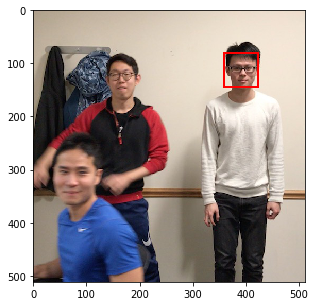

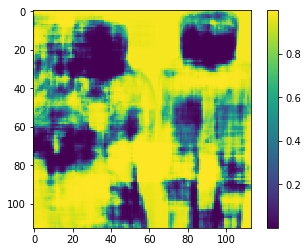

In [18]:
single_face_detection(Xtest, 'face', 512, 4, Do_facial=True)

 #### As you can see, I have a single face detection and corresponding heatmap right now. I'm going to do multi-face detection at next seciton.

## Ⅲ -  Multi-face Detection
Since the method above only picks the minimum probability, thus it draws bounding box only on one face. In order to improve my facial detection ability, I would introduce IoU technique in the following code.

#### 1 -Filtering bounding box with a threshold on probability
I am going to apply a first filter by thresholding. I would like to get rid of any box for which the probability is less than a chosen threshold (in my case, I chose threashold=0.2).
 
- a box using its two corners (upper left and lower right): (x1, y1, x2, y2)
- box_probability: the probability to be a face of  this box 

In [20]:
# Since I define a way to represent box location(using its upper left and lower right cornor) rather than
# upper left cornor which I got from coordinate list, I define a method to convert one from other.
def coord_convert_box(coord):
    box = []
    for c in coord:
        box.append((c[1], c[0], c[1]+64, c[0]+64))
    return box

In [21]:
# Filters boxes by threasholding on faces and its probability.
def filter_boxes(box_probability, boxes, threshold=0.2): 
    
    filtered_box_probability = []
    filtered_boxes = []
    
    for i, prob in enumerate(box_probability):
        if prob <= threshold:
            filtered_box_probability.append(prob)
            filtered_boxes.append(boxes[i])
    
    return filtered_box_probability, filtered_boxes

### 2-  Non-max suppression 
Even after filtering by thresholding over the probability, we still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression. 

- To calculate the area of a rectangle I need to multiply its height (y2 - y1) by its width (x2 - x1)
- I'll also define coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. 
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes

In [22]:
def IoU(box1, box2):
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area/union_area
    return iou

Now I have IoU and  ready to implement non-max suppression. The key steps are: 
- Select the box that has the highest probability(lowest box_probability in our case) if list is not empty.
- Compute its overlap with all other boxes, and remove boxes that overlap it more than iou_threshold.
- Go back to step 1 and iterate until there's no more boxes with a lower probability than the current selected box.

In [23]:
# This will remove all boxes that have a large overlap with the selected boxes.

def face_boxes(box_probability, boxes):
    facial_boxes = []
    facial_probability = []
    
    while box_probability:
        # Get the value and index of the minimum box probability.
        min_prob = min(box_probability)
        imin = box_probability.index(min_prob)
        curr_box = boxes[imin]
        
        # Append corresponding box and probability to facial_boxes 
        # waiting to be drawn in the future.
        facial_boxes.append(boxes[imin])
        facial_probability.append(min_prob)
        
        # Remove this probability and box at its index in related lists.
        box_probability.remove(min_prob)
        boxes.remove(boxes[imin])
        
        low_iou_boxes = []
        low_iou_probs = []
        for i, box in enumerate(boxes):
            iou = IoU(curr_box, box)
            if iou<0.1:
                low_iou_boxes.append(box)
                low_iou_probs.append(box_probability[i])
        
        # Update box_probability and boxes
        box_probability = low_iou_probs
        boxes = low_iou_boxes
    
    return facial_probability, facial_boxes

#### 3 - Multi-face draw method
Implement a method displaying the output (512x512x3) of the deep CNN and filtering through all the boxes using the methods I've just implemented.

In [24]:
def multi_face_draw_box(probs, coord, img, threshold=0.2, Do_multi_face=False):
    
    if Do_multi_face==True:
    
        # Step1: convert coordinates into boxes, which has upper left and lower right corner
        boxes = coord_convert_box(coord)
    
        # Step2: eliminate any boxes which has low probability to be a face
        filtered_box_probability, filtered_boxes = filter_boxes(box_probability=probs, 
                                                                boxes=boxes, 
                                                                threshold=threshold)
    
        # Step3: get rid of overlapped boxes and output the clean face boxes
        facial_probability, facial_boxes = face_boxes(filtered_box_probability, 
                                                      filtered_boxes)
    
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img[:,:,:])
    
        for face in facial_boxes:
            rect = mpatches.Rectangle((face[0], face[1]), 64, 64, fill=False, 
                                  edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        plt.show()

In [25]:
with open("face_probs.p", "rb") as fp:
    two_probs = pickle.load(fp)
with open("face_coordinate.p", "rb") as fp1:
    two_coordinate = pickle.load(fp1)

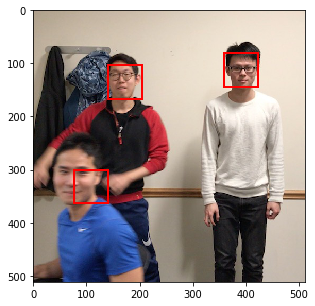

In [27]:
multi_face_draw_box(two_probs, two_coordinate, Xtest[0], 0.0001, True)

### As the end, I have finished single face and multi face detection. 